In [71]:
import numpy as np
import pandas as pd
import scanpy as sc
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, explained_variance_score
from numpy.linalg import inv, solve
import matplotlib.pyplot as plt

In [72]:
# 1. Data Normalization

def filter_genes(alpha, N, z_threshold = 1.3, ampl_threshold=0.1):
    targetnames_N = N.index
    targetnames_alpha = alpha.index
    targetnames = targetnames_alpha.intersection(targetnames_N)

    alpha = alpha.loc[targetnames]
    '''
    # Calculates amplitude over noise of alpha around the cell cycle
    mean = alpha.groupby('gene').mean().to_numpy()
    sigm = alpha.groupby('gene').std().to_numpy()
    ampl = (mean.max(axis=1)-mean.min(axis=1))/2
    zval = ampl/sigm.mean(axis=1)

    # This selects targets with zval > 2 (2 is arbitrary!!!)
    # We filter alpha for selected targets
    # N is binding site matrix for selected targets 
    ind = (zval > z_threshold) & (ampl > ampl_threshold)
    alpha = mean[ind,:]
    targetnames_filtered = targetnames[ind]
    '''
    alpha = alpha.groupby('gene').mean().to_numpy()
    N = N.loc[targetnames].to_numpy()
    #N = N.loc[targetnames_filtered].to_numpy()
    
    # Identify TFs that are not present in any gene
    inactive_tfs = np.where(N.sum(axis=0) == 0)[0]
    print(f"Number of inactive TFs: {len(inactive_tfs)}")
    N = np.delete(N, inactive_tfs, axis=1)

    return alpha, N

def normalize(E, N):
    """
    Double-center the expression matrix E.
    Subtract row means and column means and add the overall global mean.
    This yields an E' with row and column means zero.
    Center the site-count matrix N by subtracting the mean for each motif (i.e., each column).
    """
    
    global_mean = np.mean(E)
    row_mean = np.mean(E, axis=1, keepdims=True)
    col_mean = np.mean(E, axis=0, keepdims=True)
    alpha_norm = E - row_mean - col_mean + global_mean

    col_mean = np.mean(N, axis=0, keepdims=True)
    N_norm = N - col_mean
    '''
    alpha_norm, N_norm = E, N
    '''
    return alpha_norm, N_norm

In [73]:
# 2. Ridge Regression Solver

def ridge_regression_solution(N_norm, alpha_norm, lam):
    """
    Solves for A in the ridge regression model:
      (N_norm.T @ N_norm + lam^2 I) * A = N_norm.T @ alpha_norm
    Returns A, with shape (n_motifs, n_cells).
    """
    M = N_norm.T @ N_norm  # shape: (n_motifs, n_motifs)
    I = np.eye(M.shape[0])
    A = solve(M + (lam**2) * I, N_norm.T @ alpha_norm)
    return A

In [74]:
# 3. Residual Variance and Covariance Calculation, EV, z-val

def compute_residual_variance(alpha_norm, N_norm, A):
    """
    Computes the residual variance (sigma^2) per cell.
    For each cell (each column in alpha_norm), calculate the mean squared error
    between the observed alpha_norm and the predicted values from N_norm @ A.
    """
    residuals = alpha_norm - (N_norm @ A)
    sigma2 = np.mean(residuals**2, axis=0)  # one value per cell
    return sigma2

def compute_covariance_matrix(N_norm, lam):
    """
    Computes the inverse term common to all cells: inv(N_norm.T @ N_norm + lam^2 I).
    This will later be scaled by sigma^2 per cell.
    """
    M = N_norm.T @ N_norm
    I = np.eye(M.shape[0])
    inv_term = inv(M + (lam**2) * I)
    return inv_term

# 5. Explained Variance Calculation

def explained_variance(alpha_norm, R_norm):
    """
    Computes the fraction of variance explained by the model.
    """
    '''
    residuals = alpha_norm - R_norm
    mse = np.mean(residuals**2)
    total_var = np.mean(alpha_norm**2)
    f = 1 - mse / total_var
    
    return f'''
    return explained_variance_score(alpha_norm, R_norm)

def mse_metric(E, R):
    """Compute mean squared error between observed E and predicted R."""
    return np.mean((E - R)**2)

def get_z_values(alpha_norm, N_norm, A_hat, best_lam):
    # Compute residual variance per cell
    sigma2 = compute_residual_variance(alpha_norm, N_norm, A_hat)
    
    # Compute the inverse term (common for all cells) for covariance estimation
    inv_term = compute_covariance_matrix(N_norm, best_lam)
    
    # For each cell, compute the standard errors for each motif activity.
    n_motifs, n_cells = A_hat.shape
    error_bars = np.zeros((n_motifs, n_cells))
    for j in range(n_cells):
        # Standard error for each motif m in cell j: sqrt(diag(inv_term) * sigma2[j])
        error_bars[:, j] = np.sqrt(np.diag(inv_term) * sigma2[j])
    
    # Compute z-values for each motif and cell
    z_values = A_hat / error_bars
    return z_values

In [75]:
# 4. Cross-Validation to Optimize Lambda
def cross_val_lambda(N_norm, alpha_norm, lam_candidates, n_splits=5, random_state=42):
    """
    Perform KFold cross validation over promoters (rows) to select the best lambda.
    
    Parameters:
      N_norm: np.array, shape (n_promoters, n_motifs), normalized site-count matrix.
      alpha_norm: np.array, shape (n_promoters, n_cells), normalized expression matrix.
      lam_candidates: iterable of candidate lambda values.
      n_splits: int, number of folds (default 5).
      random_state: int, random seed for reproducibility.
      
    Returns:
      best_lam: the lambda value that minimizes the average MSE across folds.
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    EVs_train = []
    EVs_test = []
    MSEs_train = []
    MSEs_test = []
    
    # Loop over folds.
    for train_idx, test_idx in kf.split(N_norm):
        N_train = N_norm[train_idx, :]
        alpha_train = alpha_norm[train_idx, :]
        N_test = N_norm[test_idx, :]
        alpha_test = alpha_norm[test_idx, :]
        
        EV_fold_train = []
        EV_fold_test = []
        MSE_fold_train = []
        MSE_fold_test = []
        
        # For each candidate lambda, compute the model predictions.
        for lam in lam_candidates:
            # Fit the ridge regression model on training set:
            A_hat = ridge_regression_solution(N_train, alpha_train, lam)
            # Predictions for training and test sets:
            R_train = N_train @ A_hat
            R_test = N_test @ A_hat
            
            # Compute explained variance and MSE:
            EV_train = explained_variance(alpha_train, R_train)
            EV_test = explained_variance(alpha_test, R_test)
            MSE_train = mse_metric(alpha_train, R_train)
            MSE_test = mse_metric(alpha_test, R_test)
            
            EV_fold_train.append(EV_train)
            EV_fold_test.append(EV_test)
            MSE_fold_train.append(MSE_train)
            MSE_fold_test.append(MSE_test)
        
        EVs_train.append(EV_fold_train)
        EVs_test.append(EV_fold_test)
        MSEs_train.append(MSE_fold_train)
        MSEs_test.append(MSE_fold_test)
        print("Fold done")
    
    # Convert to arrays of shape (n_splits, len(lam_candidates))
    EVs_train = np.array(EVs_train)
    EVs_test = np.array(EVs_test)
    MSEs_train = np.array(MSEs_train)
    MSEs_test = np.array(MSEs_test)
    
    # Here, we choose the lambda that gives the highest average EV (you could also choose by lowest MSE).
    best_EV = np.max(EVs_test)
    best_MSE = np.max(MSEs_test)
    best_lam = lam_candidates[np.where(EVs_test == best_EV)[1][0]]
    
    # Plot the performance metrics vs lambda:
    plt.figure(figsize=(12, 5))
    
    # Subplot for Explained Variance:
    plt.subplot(1, 2, 1)
    for i in range(n_splits):
        plt.plot(lam_candidates, EVs_train[i], linestyle="--", color="green", alpha=0.6, label="Train" if i==0 else "")
        plt.plot(lam_candidates, EVs_test[i], linestyle="--", color="orange", alpha=0.6, label="Test" if i==0 else "")
    plt.xscale("log")
    plt.xlabel("Lambda")
    plt.ylabel("Explained Variance (EV)")
    plt.title("Explained Variance vs Lambda")
    plt.legend()
    plt.grid(True)
    
    # Subplot for Mean Squared Error:
    plt.subplot(1, 2, 2)
    for i in range(n_splits):
        plt.plot(lam_candidates, MSEs_train[i], linestyle="--", color="blue", alpha=0.6, label="Train" if i==0 else "")
        plt.plot(lam_candidates, MSEs_test[i], linestyle="--", color="magenta", alpha=0.6, label="Test" if i==0 else "")
    plt.xscale("log")
    plt.xlabel("Lambda")
    plt.ylabel("Mean Squared Error (MSE)")
    plt.title("MSE vs Lambda")
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

    return best_lam, best_EV, best_MSE

In [76]:
#Final perf evaluation on best lambda
def train_best_model(N_norm, alpha_norm, best_lam, n_splits=5, random_state=42):
    # Define the number of folds
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    print("Train for lambda =", best_lam)

    # Perform K-Fold cross-validation
    for train_idx, test_idx in kf.split(N_norm):
        N_train = N_norm[train_idx, :]
        alpha_train = alpha_norm[train_idx, :]
        N_test = N_norm[test_idx, :]
        alpha_test = alpha_norm[test_idx, :]

        # Solve ridge regression for current lambda on the training set.
        A_hat = ridge_regression_solution(N_train, alpha_train, best_lam)
        R_train = N_train @ A_hat
        R_test = N_test @ A_hat
        # Predict on the test set.
        EV_train = explained_variance(alpha_train, R_train)
        EV_test = explained_variance(alpha_test, R_test)
        MSE_train = mse_metric(alpha_train, R_train)
        MSE_test = mse_metric(alpha_test, R_test)
        print("EV_train :", round(EV_train*100,2), "%", "MSE_train :", round(MSE_train,2))
        print("EV_test :", round(EV_test*100,2), "%", "MSE_test :", round(MSE_test,2), "\n")
        
    return A_hat

(122380, 100) (13568, 370)
Number of inactive TFs: 0
(8772, 100) (8772, 370)
Fold done
Fold done
Fold done
Fold done
Fold done


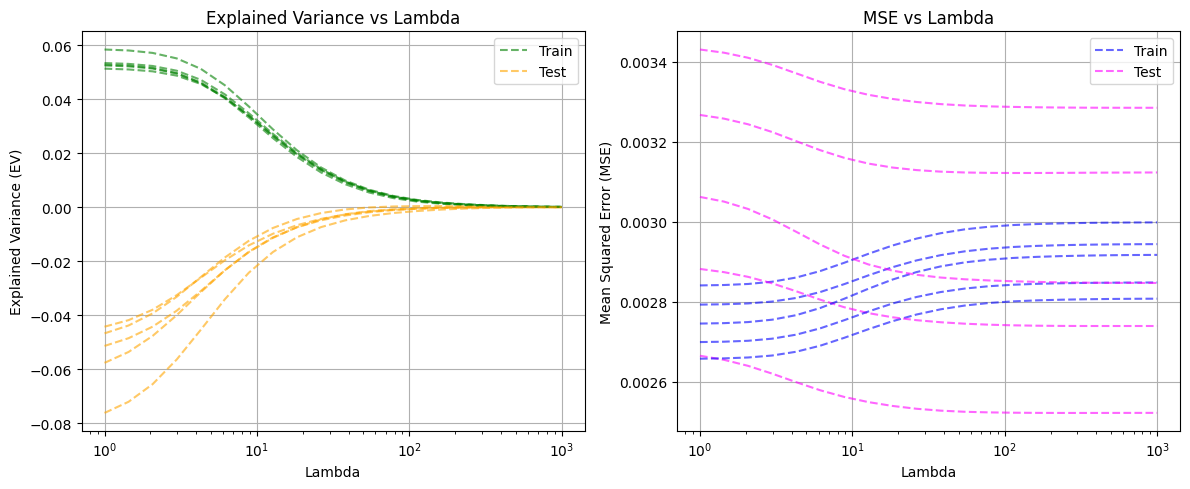

Best lambda: 162.3776739188721
Best EV: 0.0003821240541503157
Best MSE: 0.00343025254888607


In [77]:
fileAlpha = "Data/bootstrap_alpha_scrna_100_1_1.csv"
fileBSM = 'Data/data_binding_site_matrix.txt'

N = pd.read_csv(fileBSM, sep="\t",index_col=0)
alpha = pd.read_csv(fileAlpha, sep=",",index_col=0)

#Select common genes between E and N
print(alpha.shape, N.shape)
alpha, N = filter_genes(alpha, N, z_threshold=1.3, ampl_threshold=0.1)
print(alpha.shape, N.shape)

# Normalize the data
alpha_norm, N_norm = normalize(alpha, N)

# Define candidate lambda values (you may adjust this range as needed)
lam_candidates = np.logspace(0, 3, 20)  # from 0.001 to 10
best_lam, best_EV, best_MSE = cross_val_lambda(N_norm, alpha_norm, lam_candidates, random_state=43)
print("Best lambda:", best_lam)
print("Best EV:", best_EV)
print("Best MSE:", best_MSE)

In [78]:
A_hat = train_best_model(N_norm, alpha_norm, best_lam, random_state=48)
#z_values = get_z_values(alpha_norm, N_norm, A_hat, best_lam)

Train for lambda = 162.3776739188721
EV_train : 0.16 % MSE_train : 0.0
EV_test : -0.05 % MSE_test : 0.0 

EV_train : 0.16 % MSE_train : 0.0
EV_test : -0.03 % MSE_test : 0.0 

EV_train : 0.15 % MSE_train : 0.0
EV_test : -0.02 % MSE_test : 0.0 

EV_train : 0.15 % MSE_train : 0.0
EV_test : -0.03 % MSE_test : 0.0 

EV_train : 0.14 % MSE_train : 0.0
EV_test : 0.02 % MSE_test : 0.0 

